# Fit a metallicity gradient

This is a demo showing how FRApy can be used to fit a simple linear metallicity gradient.

The data being fit is a beautiful grand desing spiral galaxy at z=0.611, lensed by the cluster AS1063. We call it, imaginativelly, AS1063-arc. 

![A370](img/as1063_image_plane.png)


More information about this galaxy/ The analysis was published in __[Patricio et al. 2018](https://academic.oup.com/mnras/advance-article/doi/10.1093/mnras/sty555/4919636?guestAccessKey=68f01c9f-8a00-4d7a-b398-c74a3a0c2c9a)__

In [17]:
# For prettiness
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt

# Temporary work-around
import sys
frapy_path = '../'
sys.path.append(frapy_path)
sys.path

# Import FRApy
from frapy import Observation,Metallicity_Gradient,fit_model,make_input_parameters,Output

## Observations

Let's start by loading our observations, in this case, a metallicity map of the galaxy above observed with MUSE.

We'll use a *Observation* class to do this

In [2]:
obs = Observation(z=0.611,
                  data_path='Demo_data/AS1063_map_metallicity.fits',
                  unc_path='Demo_data/AS1063_map_metallicity_unc.fits',
                  seeing = 1.03/0.2)

We can have a look at what is in the obs object, using info and plot:

In [3]:
obs.info()

Data: Demo_data/AS1063_map_metallicity.fits
Redshift: 0.611
Seeing (in pixels): 5.1499999999999995
Uncertainty: Demo_data/AS1063_map_metallicity_unc.fits


<IPython.core.display.Javascript object>


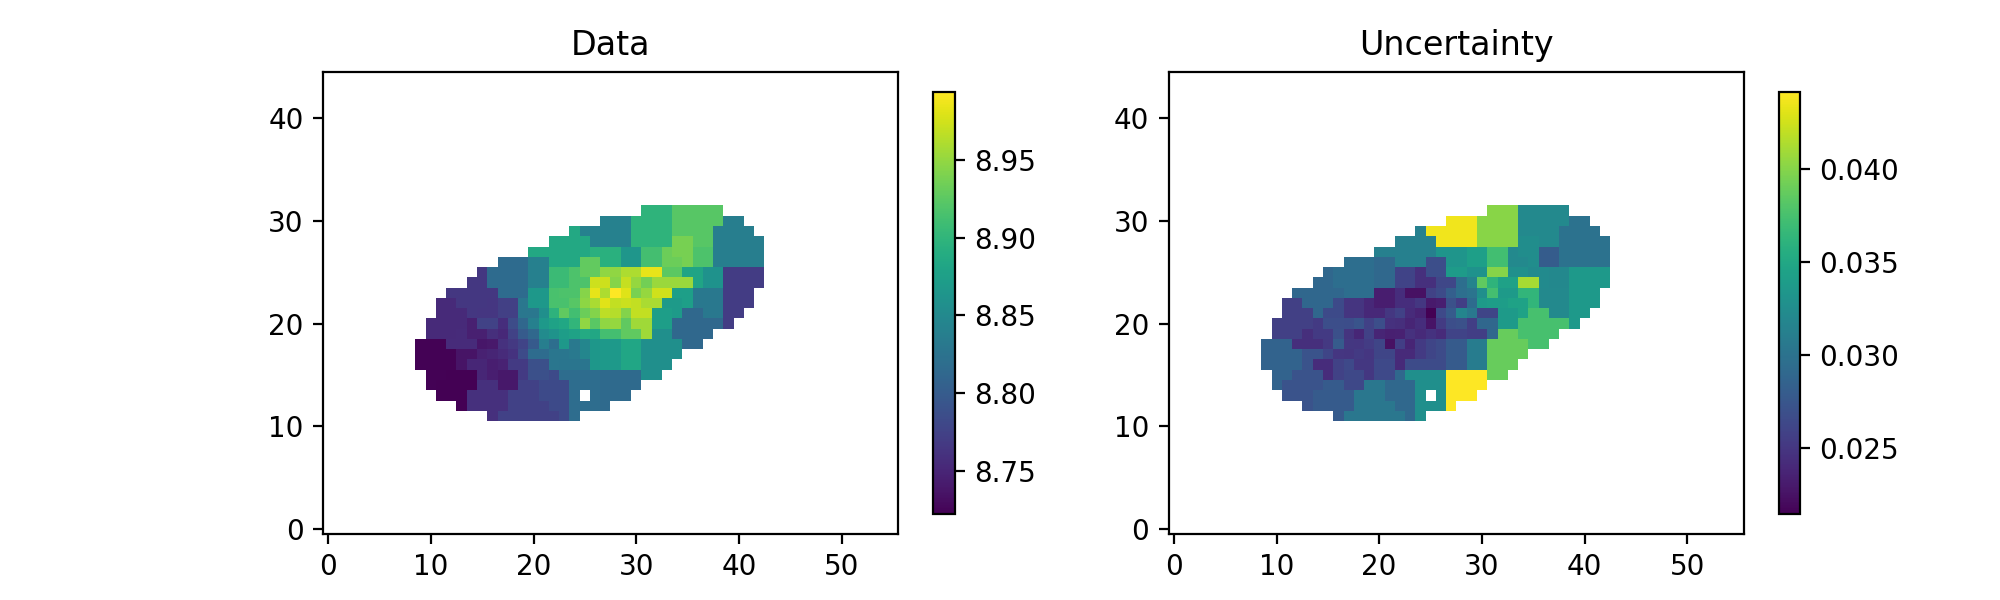

In [4]:
obs.plot()

## Model

Now let's create a model, in this case a metallicity gradient.

We need to include the lensing model in order to be able to take the original model and 'distort' it the same way the data was 'changed' by the graviational lens.

This is done using the deflection maps.

(If you want to have a look at the models in source plane (without lensing) you can use the AS1063_no_lensing_dpl.fits file. This is a file full with zeros, meaning that each pixel in source plane is 'deflected' by zero arcseconds in image plane, so effectivelly there is no lensing)

In [5]:
model = Metallicity_Gradient(zlens=0.322,
              dfx_path='Demo_data/AS1063_dplx.fits',
              dfy_path='Demo_data/AS1063_dply.fits')
              #dfx_path='Demo_data/AS1063_no_lensing_dpl.fits',
              #dfy_path='Demo_data/AS1063_no_lensing_dpl.fits')

We can have a look at the lensing information and also at the parameters of the particular model we are using

In [6]:
model.lensing_info()

Lens redshift: 0.3220
Deflection map (x): Demo_data/AS1063_dplx.fits
dDflection map (y): Demo_data/AS1063_dply.fits


In [7]:
model_parameters = model.model_parameters(verbose=True)

cx: x position of the centre (in pixels)
cy: y position of the centre (in pixels)
q: axis ratio (a/b)
pa: position angle (in degrees)
z_grad : gradient in dex/kpc
z_0: central metallicity


All models (gradients but also velocity) are based on a distance map that is calculated in source plane and lensed to image plane using the displacement maps.

However, the displacement maps given in dplx_path and dply_path, are the global displacement maps (i.e not calculated for a particular source redshift or position) and they need to be tweaked before a distance map for the source we are analysing can be produced. 

If we try to create a distance map at this point, an error message will appear:

In [8]:
model.make_distance_map()

No deflection maps for a particular redshift were found.
It is not possible to create a distance map without them.
Use the "create_deflection_maps_for_object" method first.


Using the *make_displacement_maps_for_object* for our observations (passing the observation object we created before), we will be creating the correct displacement maps for this object, with the displacement in the correct units and aligned with our data, ready to be used.

(In this case, the dpl files have already been adapted to the redshift of the source, so we use the correct_z=False and this method will only align the displacement maps with the data).

In [9]:
model.create_projection_maps(obs,correct_z=False)

If we now try again to obtain a distance map (in kpc), it should work

<IPython.core.display.Javascript object>


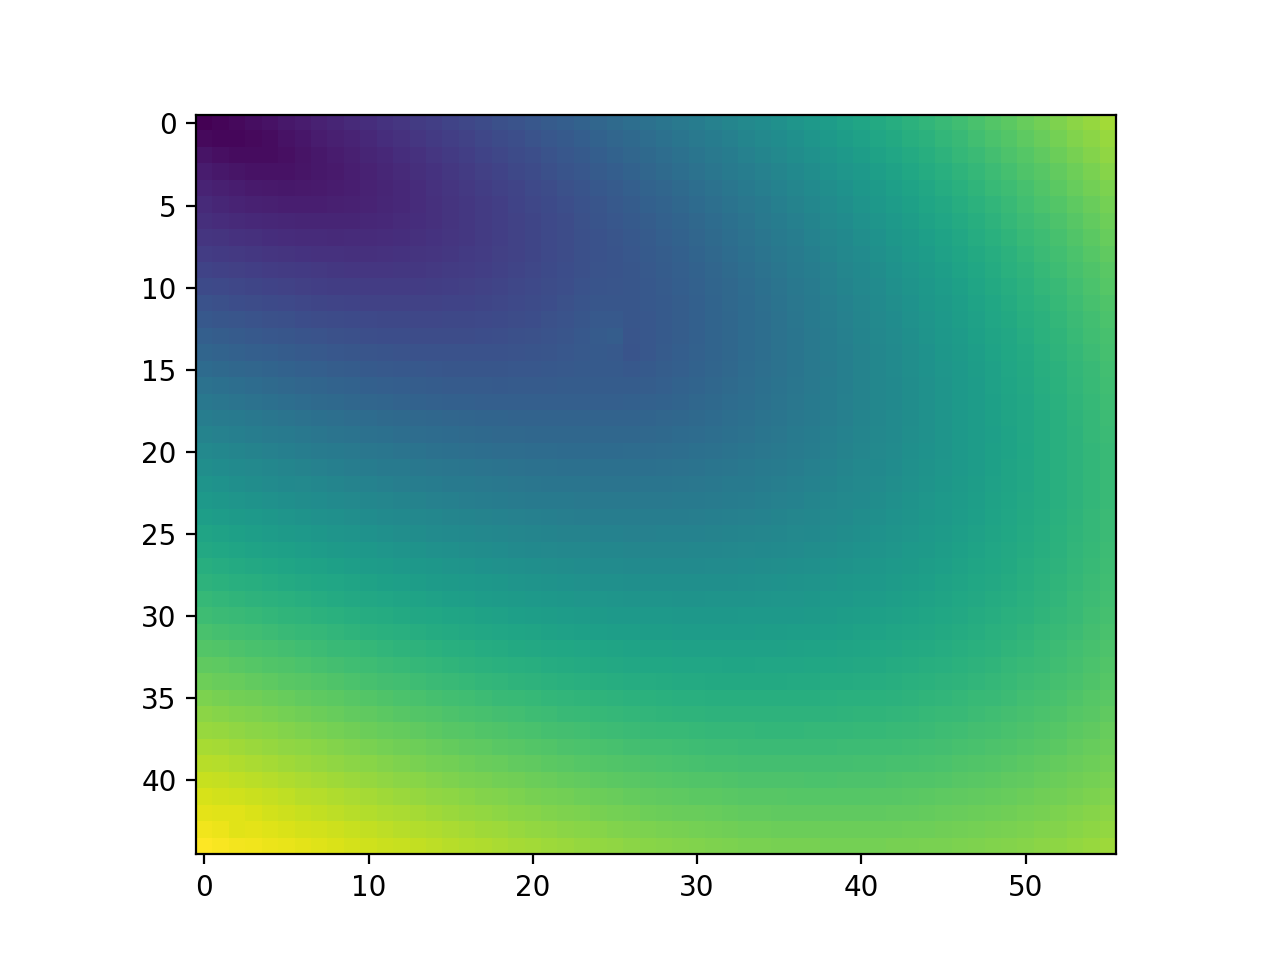

In [10]:
dist = model.make_distance_map()
plt.figure()
plt.imshow(dist)

We can also produce the actual model we are interested in (most of the times we won't need the distance map, this is just an intermediate step common to all models)

<IPython.core.display.Javascript object>


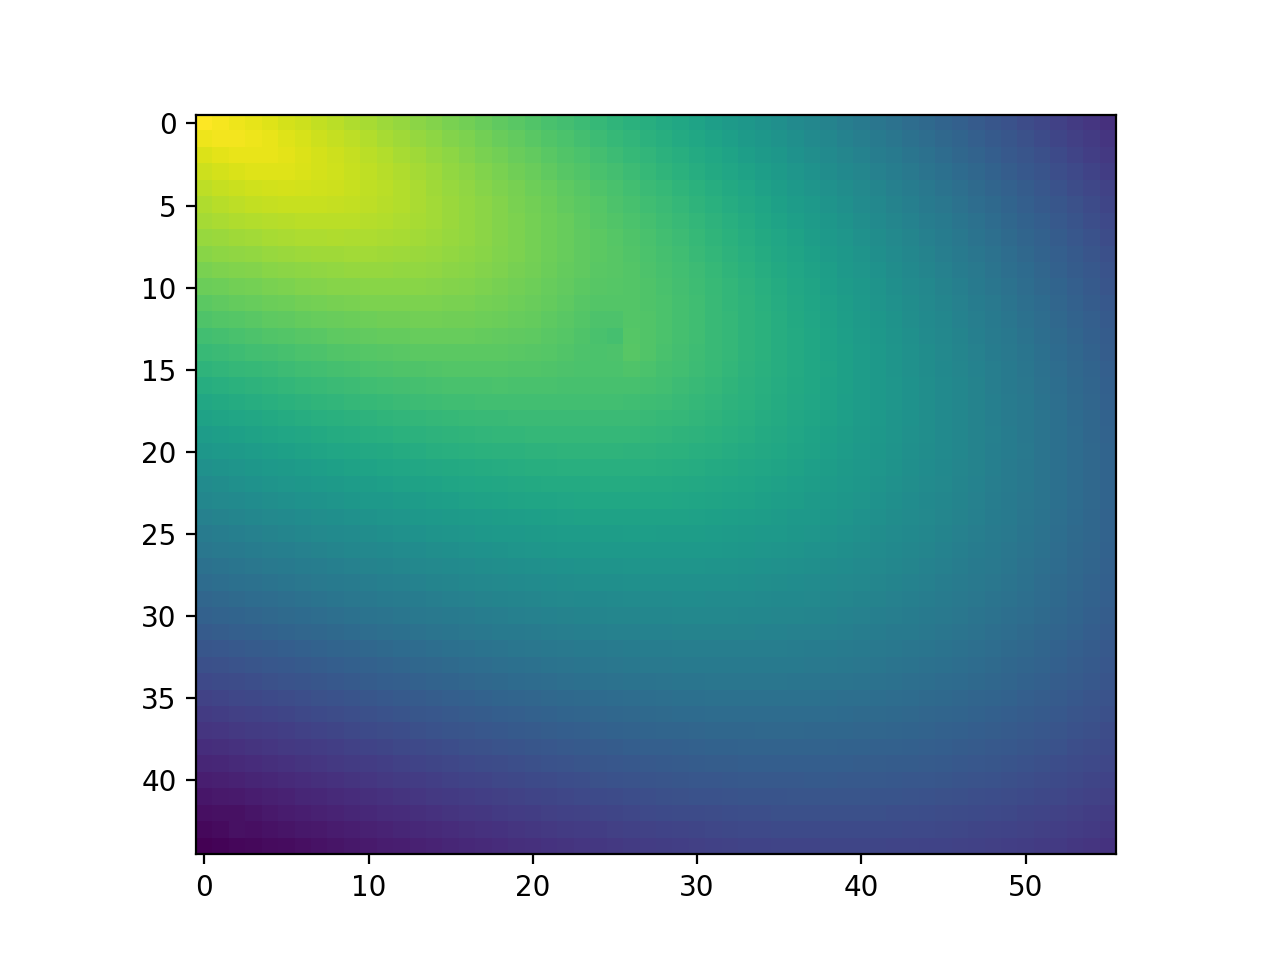

In [11]:
dummy_gradient = model.make_model()

plt.figure()
plt.imshow(dummy_gradient)

Our dummy gradient is indeed a bit dummy, since the initial parameters are not very sensible.

In [12]:
model.print_parameter_values()

cx: 0
cy: 0
q: 1.00
pa: 0.00
z_grad: -1.00
z_0: 0.00


We can update the parameters and get something nicer:

<IPython.core.display.Javascript object>


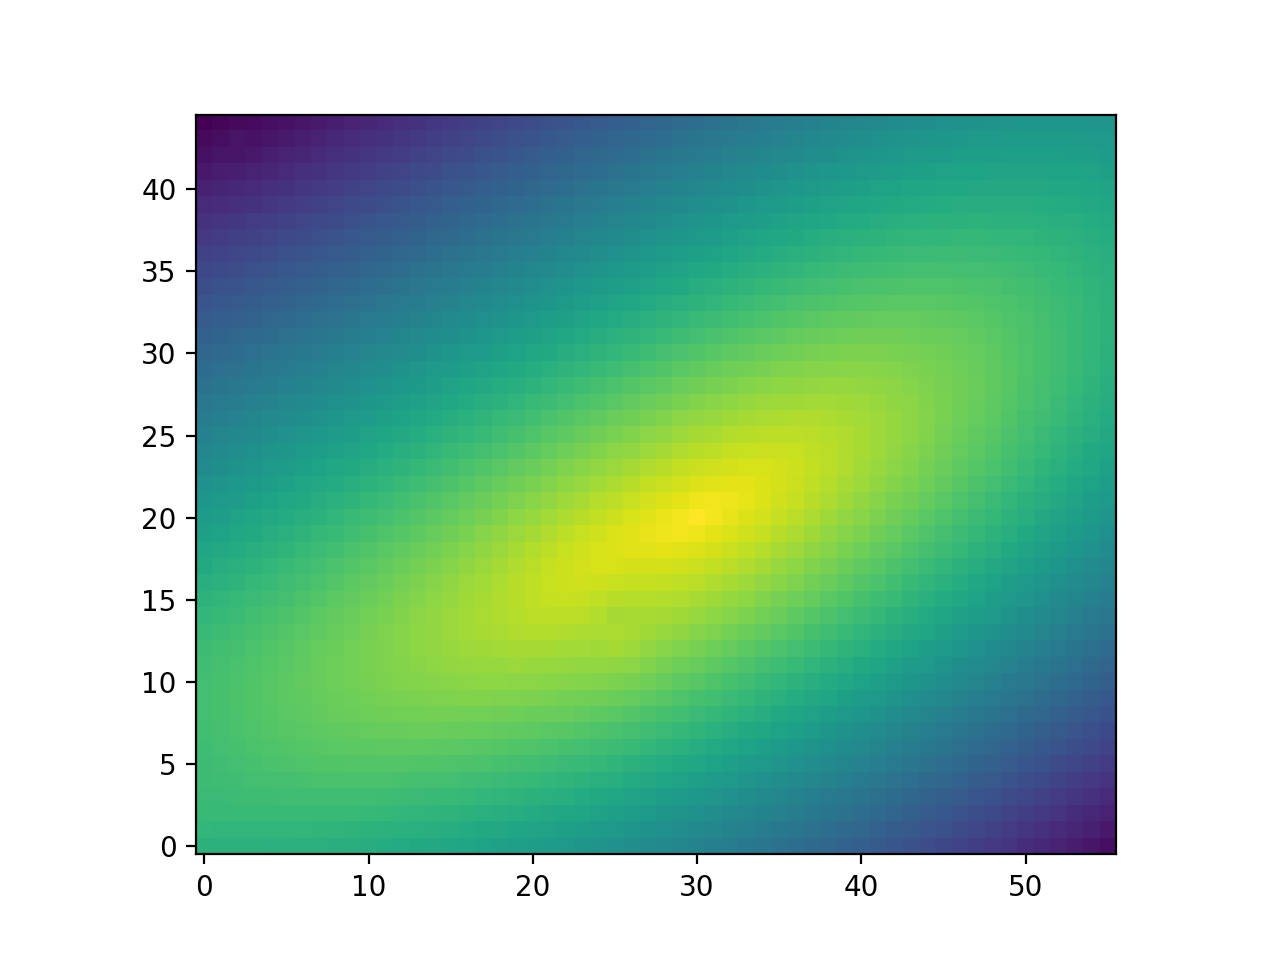

In [13]:
model.cx = 30
model.cy = 20
model.q = 0.8
model.pa = -20
model.z_grad = -0.2
model.z_0 = 8.5

more_sensible_model = model.make_model()

plt.figure()
plt.imshow(more_sensible_model,origin='lower')

The data is now also available in model.data and it can be directly showed with model.plot()

<IPython.core.display.Javascript object>


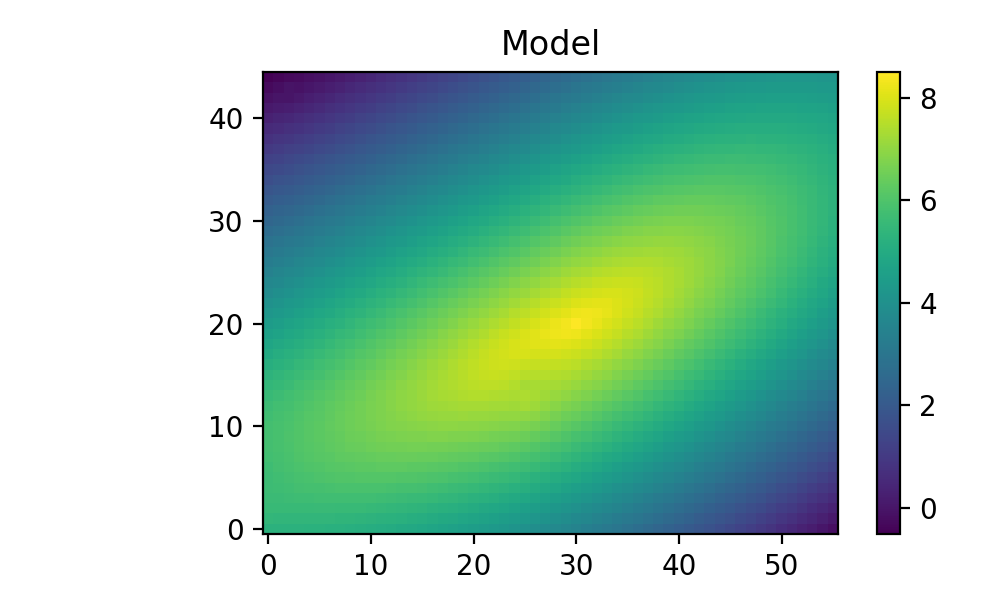

In [14]:
#model.data # output the array 
model.plot()

## Fitting

Now we will try to fit the model to the data. We use the __[emcee](http://dfm.io/emcee/current/ )__ sampler to make this.

A couple of things to notice:

We assume uniform priors for all parameters (maybe not the smartest, but maybe the safest).

We are maximising the following (log)-probability function:
    
$$ln(probability) = ln(priors) + ln(likelihood)$$
        
   with
   
$$ln(likelihood) = -\frac{1}{2} \big( \frac{(data-model)^2}{uncertainty^2} + ln(2\, \pi\, uncertainty^2)\big)$$
   
       

We need both the model and the observation objects we made before, but we also have to 'tell' the fitter which parameters are going to be fit and how much they are allowed to vary.

We do this using a nested dictionary, in the form:

       {parameter_name1:{'value':X, 'min':Y, 'max':Z},
        parameter_name2:{'value':A, 'min':B, 'max':C},
        ...
        }

You can build your own, or use the *make_input_parameters* auxiliary function to do this for you.

**Note:** the parameter names have to be exactly the names of the parameters of the model you're using. You can check this using model.model_parameters().

In [15]:
# We can access the all the possible parameter names to put in 'name' with:
#parameter_names = model.model_parameters()
input_par = make_input_parameters(name    = ('cx', 'cy',  'q', 'pa', 'z_grad', 'z_0'),
                                 value   = (  29,   23,  0.7,   20,    -0.02, 9.0),
                                 minimum = (  28,   22,  0.4,  -20,     -0.1, 8.5),
                                 maximum = (  33,   27,  0.9,   90,      0.0, 9.5))

print(input_par)

{'cx': {'value': 29, 'min': 28, 'max': 33}, 'cy': {'value': 23, 'min': 22, 'max': 27}, 'q': {'value': 0.7, 'min': 0.4, 'max': 0.9}, 'pa': {'value': 20, 'min': -20, 'max': 90}, 'z_grad': {'value': -0.02, 'min': -0.1, 'max': 0.0}, 'z_0': {'value': 9.0, 'min': 8.5, 'max': 9.5}}


Actually fitting!

You can choose how many walkers you want/need and how many steps. You might have to play a little with these to make sure your solution has converged (more bellow)

In [16]:
out = fit_model(obs=obs,
                model=model,
                parameters=input_par,
                outputname='as1063_metallicity',
                nsteps=2000,
                nwalkers=24)

Using 24 walkers and fitting dict_keys(['cx', 'cy', 'q', 'pa', 'z_grad', 'z_0']):
MCMCing for 2000 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 1.6362 minutes


## Check fit

Here will check if the fit has converged and will plot the solution found.

In [2]:
results = Output('as1063_metallicity')

<IPython.core.display.Javascript object>


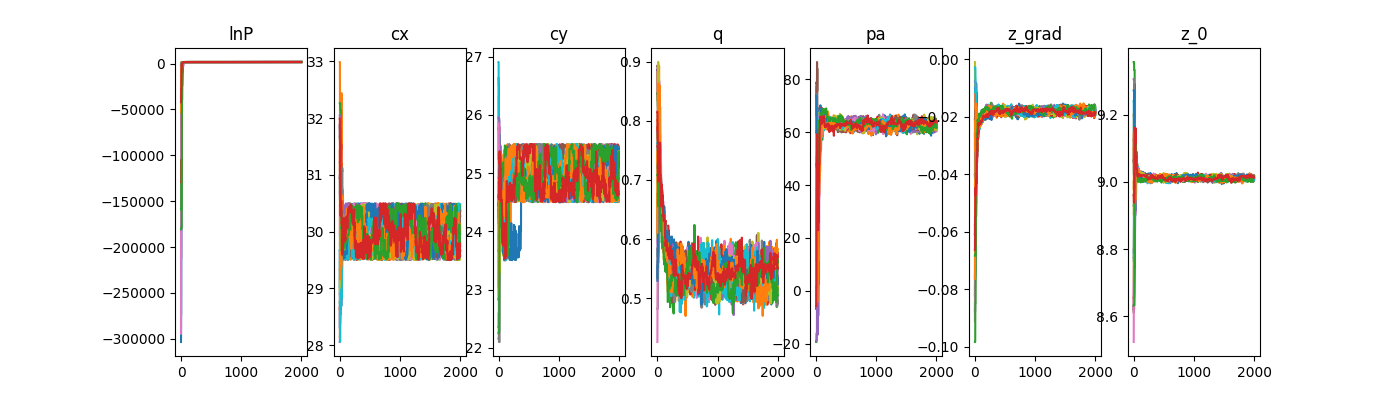

In [3]:
results.check_convergence()

It does look like it has converged. Let's look at the results of the last 1000 iterations, way after it the walkers have settled. We use a corner plot to check how much each parameter varies at what is its dependence of the other parameters.

<IPython.core.display.Javascript object>


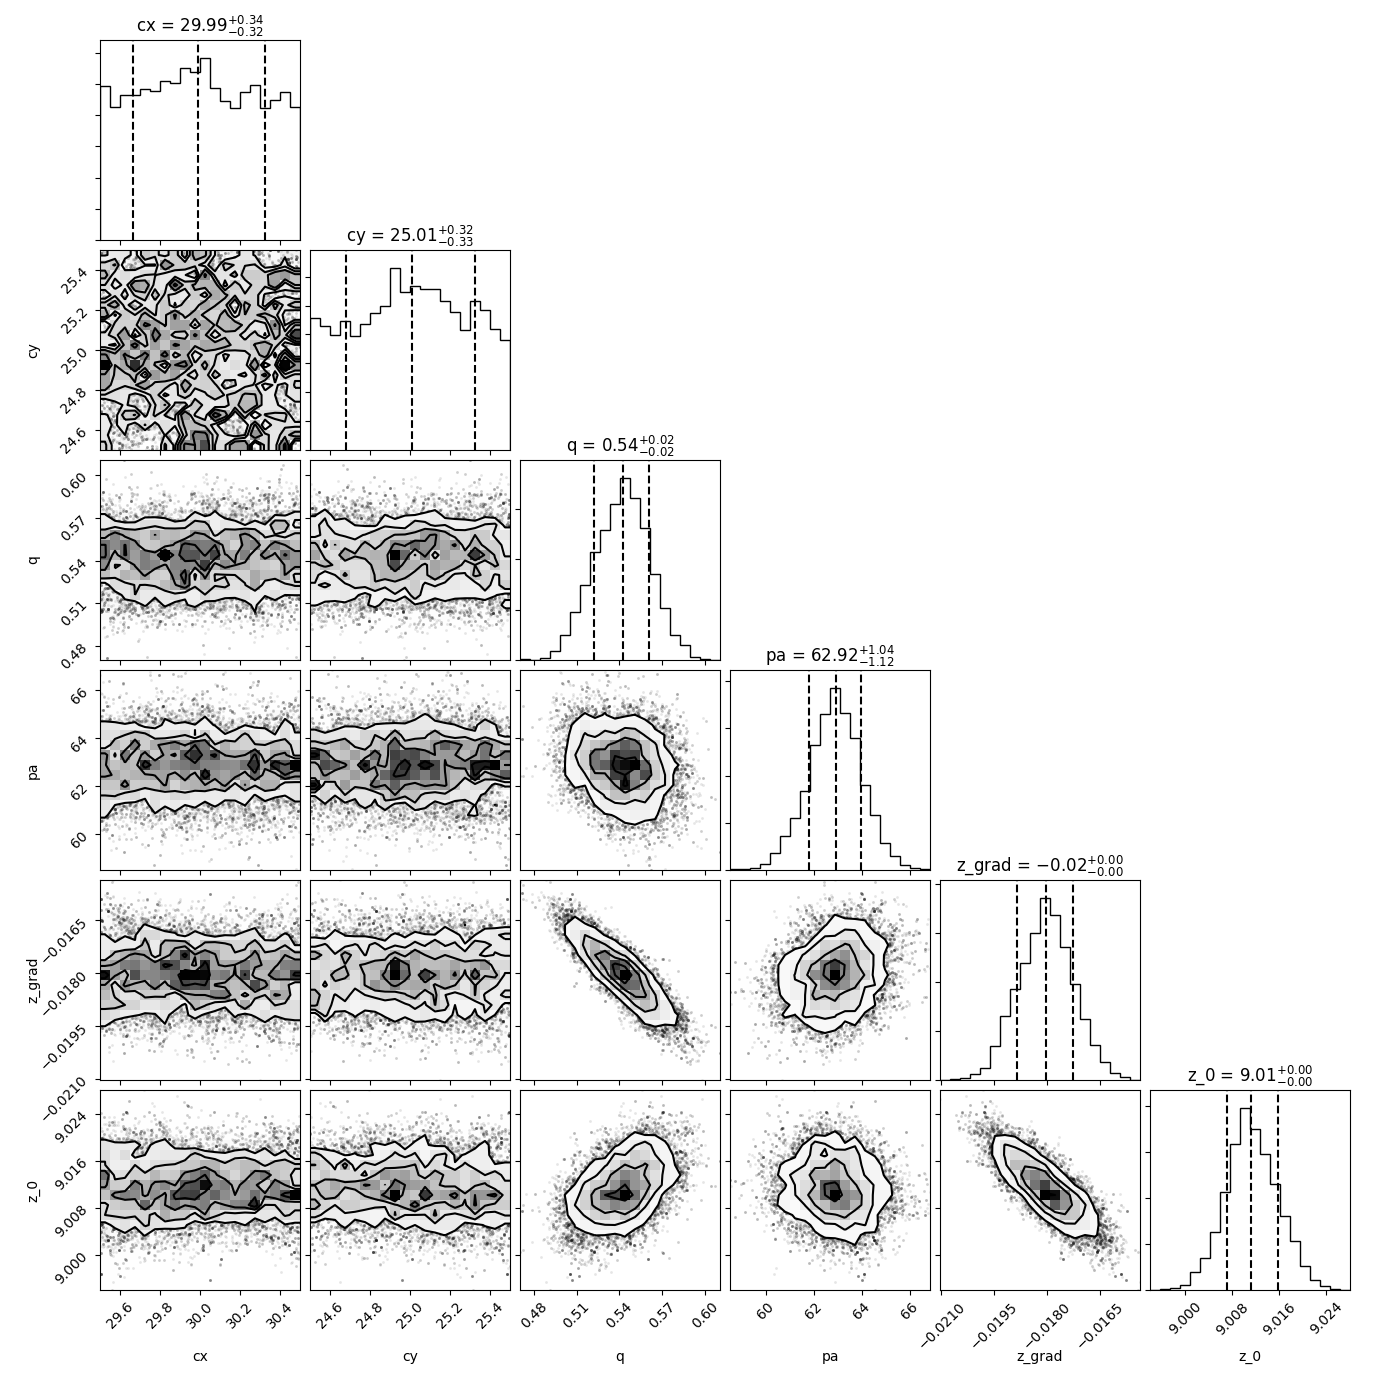

In [4]:
results.make_cornerplot(start=1000)

We take the 50th percentile of the values of the walkers of the last 1000 iterations to be our 'best guess' at the parameter values, and the 18th and 84th percentiles as the uncertainty. 

The best_parameters returns these values in a dictionary with the +/- 1 sigma and mean of the samples (from *start* to the end) for each parameter:

In [9]:
best_param = results.best_parameters(start=1000)

cx 29.9894$^{+0.3373}_{-0.3222}$
cy 25.0078$^{+0.3173}_{-0.3287}$
q 0.5426$^{+0.0180}_{-0.0206}$
pa 62.9203$^{+1.0382}_{-1.1213}$
z_grad -0.0180$^{+0.0008}_{-0.0008}$
z_0 9.0112$^{+0.0047}_{-0.0040}$


In [10]:
best_param

{'cx': {'value': 29.989383007859722,
  'min': 0.33725161076366916,
  'max': 0.3222391918661174},
 'cy': {'value': 25.007827839528424,
  'min': 0.3173207714194426,
  'max': 0.3286737500331185},
 'q': {'value': 0.5426491345002522,
  'min': 0.017983827925920015,
  'max': 0.020580421124203552},
 'pa': {'value': 62.920321118752234,
  'min': 1.0382095828833187,
  'max': 1.121300480415023},
 'z_grad': {'value': -0.018016160353113334,
  'min': 0.0007614745608764961,
  'max': 0.0008219425557366294},
 'z_0': {'value': 9.011164504634536,
  'min': 0.004686587976660661,
  'max': 0.004008007779084721}}

Using this dictiorary, we can produce the corresponding model.

(Or you can directly modify the model's parameters)

<IPython.core.display.Javascript object>


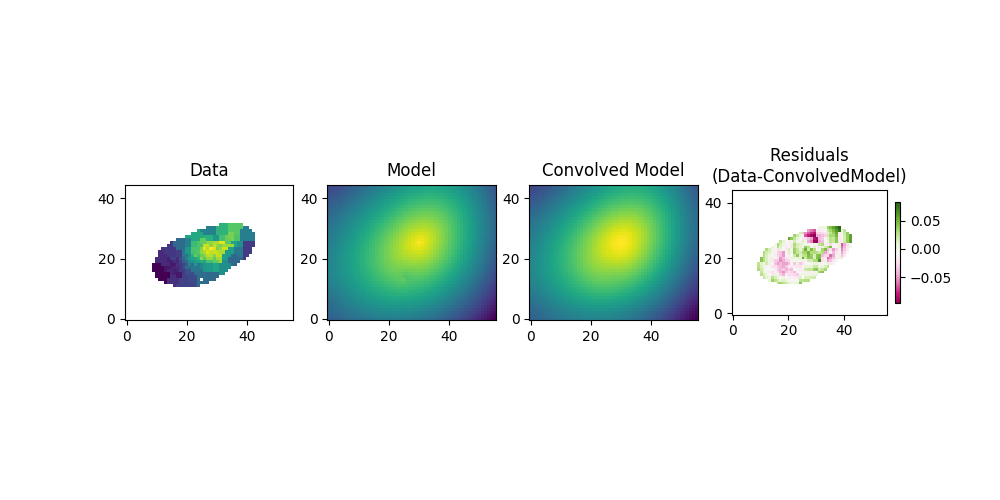

In [12]:
model, residuals = results.plot_solution(best_param)

Some basic goodness of fit metrics can also be calculated:

In [13]:
chi2_dof = results.goodness_of_fit(best_param)

Chi2: 461.04
Chi2/dof: 11.82
Loglikelihood: 1672
BIC: -3321


### Fixing some parameters

It is also possible to fix some parameters. To do this, we set the fixed parameters to their value in the model object and then construct an input parameter dictionary without these fixed parameters.

In [30]:
# First we set the parameters to the values we do not want to vary:
model.cx = 28
model.cy = 22
# Then we cosntruct a dictionary with the remaining parameters
par_fixed_centre = make_input_parameters(name    = ('q', 'pa', 'z_grad', 'z_0'),
                                         value   = (0.7,   20,    -0.02, 9.0),
                                         minimum = (0.4,  -20,     -0.1, 8.5),
                                         maximum = (0.9,   90,      0.0, 9.5))

print(par_fixed_centre)

{'q': {'value': 0.7, 'min': 0.4, 'max': 0.9}, 'pa': {'value': 20, 'min': -20, 'max': 90}, 'z_grad': {'value': -0.02, 'min': -0.1, 'max': 0.0}, 'z_0': {'value': 9.0, 'min': 8.5, 'max': 9.5}}


In [31]:
out2 = fit_model(obs,model,par_fixed_centre,'as1063_metallicity_fixed_centre',nsteps=2000,nwalkers=24)

Using 24 walkers and fitting dict_keys(['q', 'pa', 'z_grad', 'z_0']):
MCMCing for 2000 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 1.6880 minutes


In [32]:
res_fixed_centre = Output('as1063_metallicity_fixed_centre')

<IPython.core.display.Javascript object>


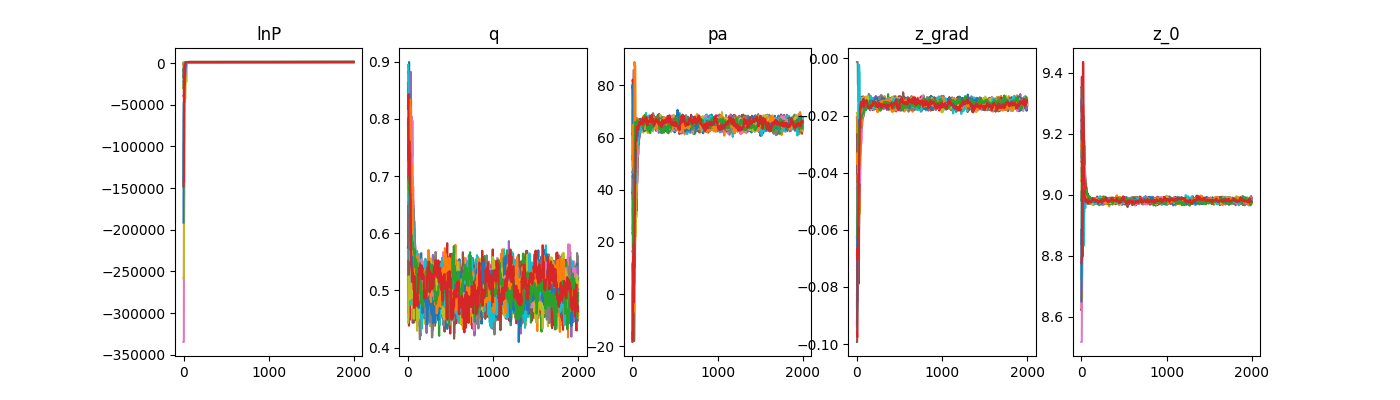

<IPython.core.display.Javascript object>


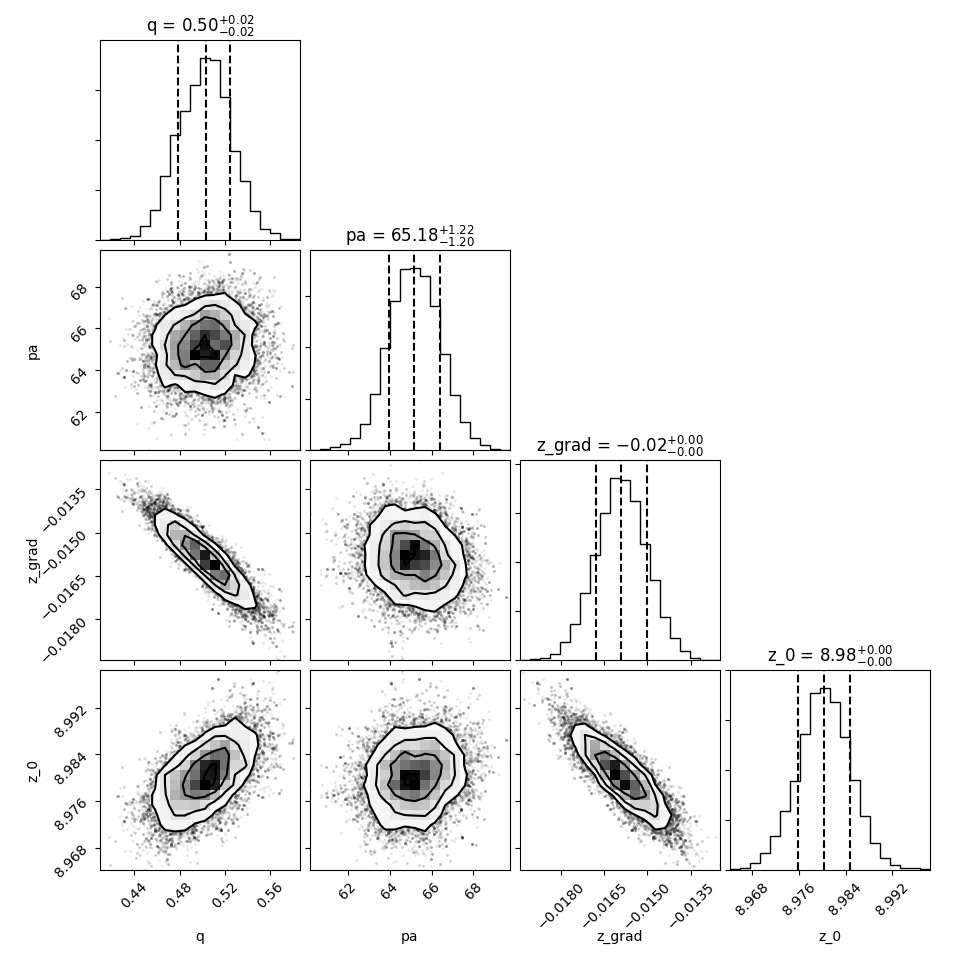

In [33]:
res_fixed_centre.check_convergence()
res_fixed_centre.make_cornerplot(start=1000)

## Take the data binning into account

!This is not a function to bin the data! 

But if the data was binned in order to derive the image being fitted it is possible to take that into account, passing a 'binning_map' into the fitting function.

This binning maps should have the same size as the data, and each bin should have a different (and unique) value. **Pixels not used should be assigned a(ny) negative number**. This also indirectly acts as a mask, since pixels without an assigned bin number will not be included when calculating the log-likelihood.


The data used in this demo was binned using the Voronoi binning code from  Cappellari & Copin (2003, MNRAS, 342, 345) available here: http://www-astro.physics.ox.ac.uk/~mxc/software/.

<IPython.core.display.Javascript object>


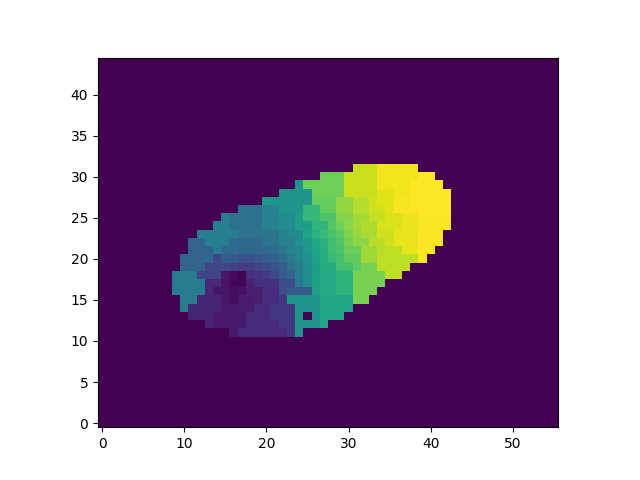

In [34]:
from astropy.io import fits

voronoi_map = fits.getdata('Demo_data/AS1063_binning_map.fits')
plt.figure()
plt.imshow(voronoi_map,origin='lower')

And now we can fit the data including this binning. This means that the maximisation of the log-likelihood function will be done over the bins and not over the pixels. This is **much slower** than the fitting without the binning

In [37]:
out3 = fit_model(obs,model,input_par,'as1063_metallicity_binned',nsteps=2000,nwalkers=24,binning_map='Demo_data/AS1063_binning_map.fits')

Using 24 walkers and fitting dict_keys(['cx', 'cy', 'q', 'pa', 'z_grad', 'z_0']):
MCMCing for 2000 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 12.6306 minutes


In [38]:
res_binned = Output('as1063_metallicity_binned')

<IPython.core.display.Javascript object>


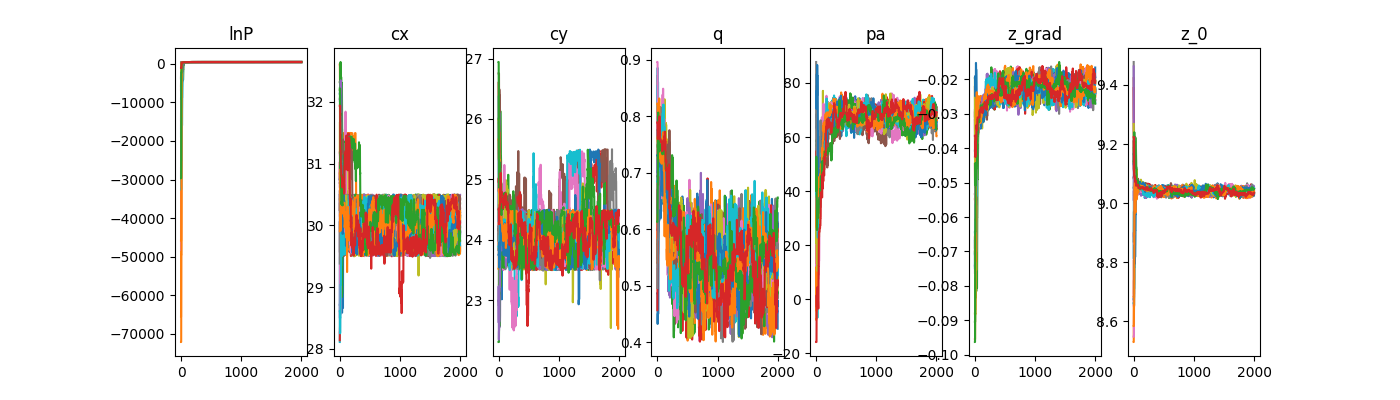

<IPython.core.display.Javascript object>


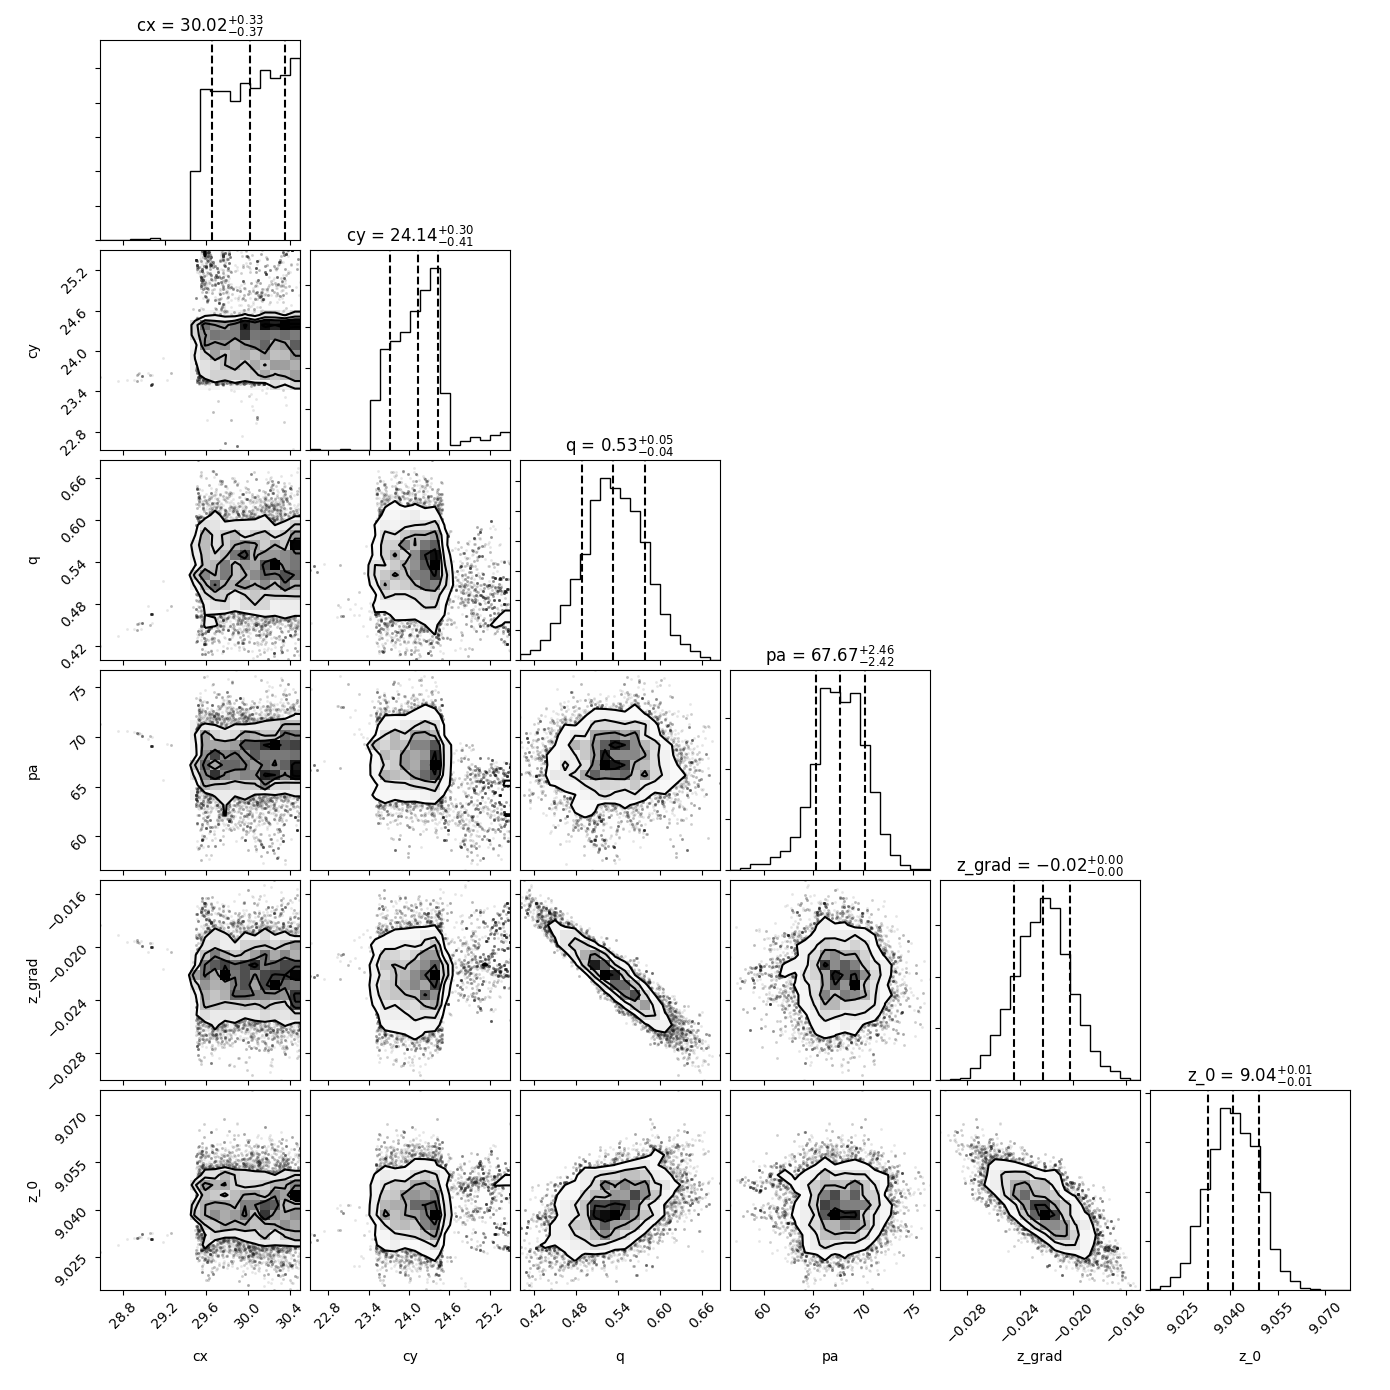

In [39]:
res_binned.check_convergence()
res_binned.make_cornerplot(start=1000)

## Masking parts of the data

Another option is to mask parts of the data. This can be done my providing a mask image. This should contain only ones (valid pixels) or zeros (masked pixels). Although mask and binning can be used at the same time, they can be are redundant (pixels with negative values in the binning image are effectivelly masked).

<IPython.core.display.Javascript object>


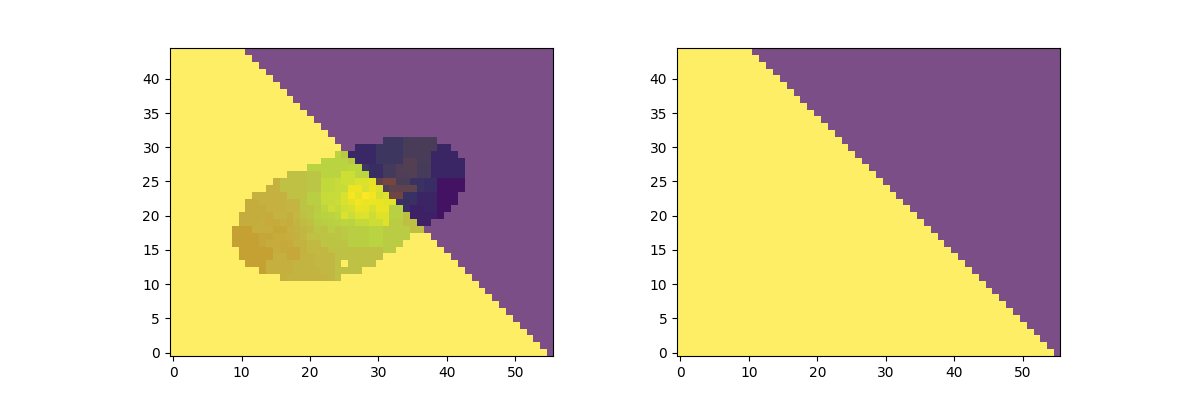

In [40]:
import numpy as np

mask = np.ones_like(obs.data)

x, y = np.meshgrid(range(obs.data.shape[0]),range(obs.data.shape[1]))
mask = x < 55 - 1*y
mask = mask.T

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(obs.data,origin='lower')
ax[0].imshow(mask,origin='lower',alpha=0.7)
ax[1].imshow(mask,origin='lower',alpha=0.7)

In [41]:
out4 = fit_model(obs,model,input_par,'as1063_metallicity_masked',nsteps=2000,nwalkers=24,mask=mask)

Using 24 walkers and fitting dict_keys(['cx', 'cy', 'q', 'pa', 'z_grad', 'z_0']):
MCMCing for 2000 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 1.5843 minutes


And we do as usual

In [42]:
res_masked = Output('as1063_metallicity_masked')

<IPython.core.display.Javascript object>


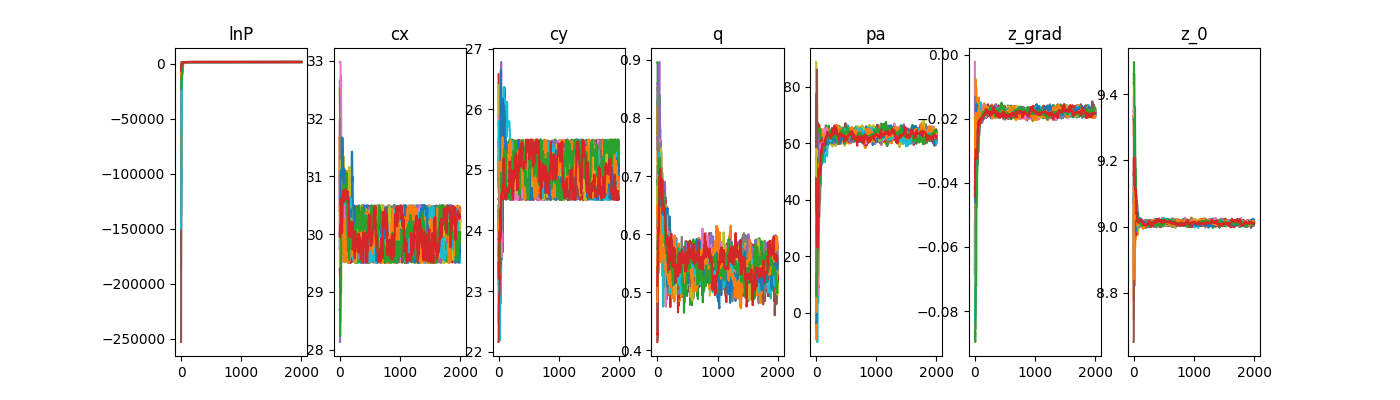

<IPython.core.display.Javascript object>


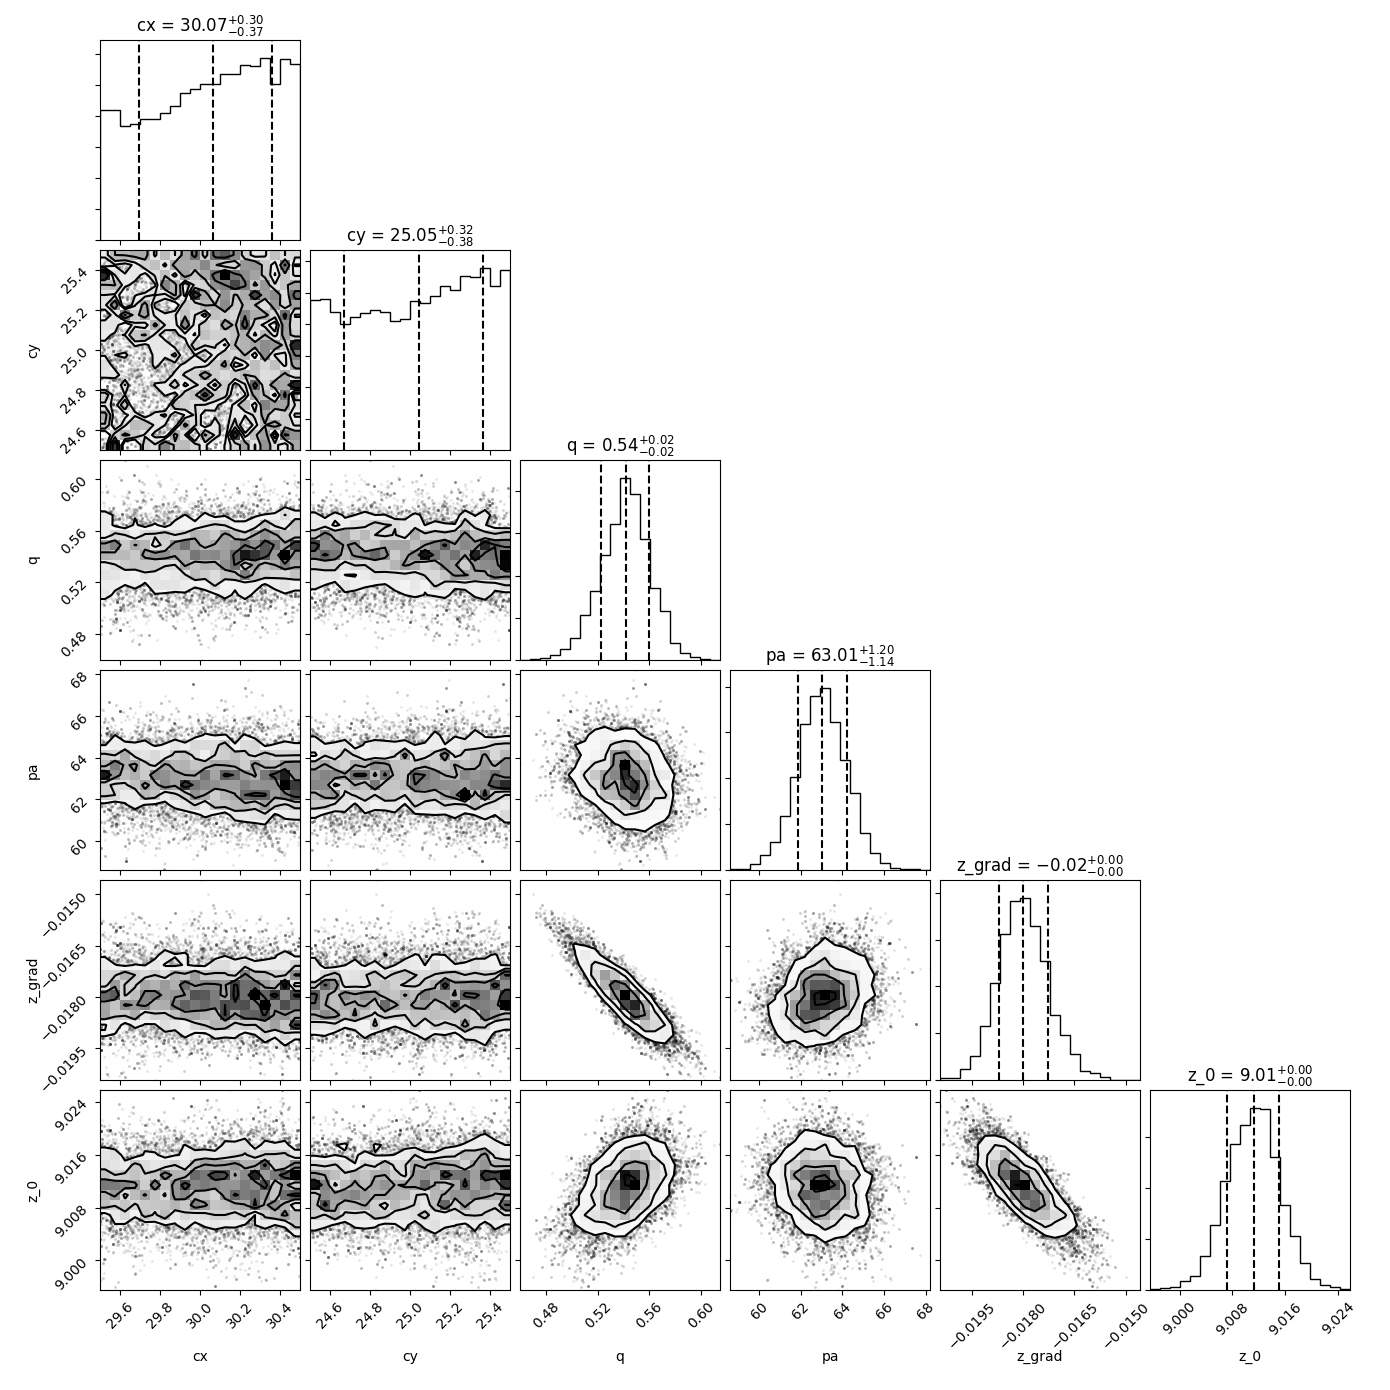

In [43]:
res_masked.check_convergence()
res_masked.make_cornerplot(start=1000)

You can also try this with the data from another galaxy in the cluster Abell 370, known as the snake. All the files you need are in the Demo_data folder.